##############################################################################
##############################################################################
### **Atelier "Comprendre et développer des CNN pour le traitement d'images"**
##############################################################################
##############################################################################
<br>
<br>
<br>
<br>

#### **Partie 3 : Développement d'un CNN de classification d'images satellitaires par finetuning** 


Dans cette trois partie, nous allons développer un modèle CNN  à partir d'un modèle de fondation afin de classifier correctement des images satellitaires de 4 types : désert, foret, océan et nuageux.

<br>

Les modèles de fondation sont de très gros modèles ayant appris à classifier souvent une grande quantité de classes. Le "savoir" contenu à l'intérieur permet de les réentrainer sur des datasets extrèmement différents, où ils vont montrer de très bonnes performances très rapidement, souvent meilleurs que les modèles " from scratch". C'est ce que nous allons tenter de démontrer ici
<br>
<br>
############################################################
<br>
<br>



<br>

#### **Import des librairies utiles pour l'atelier**

L'atelier se base sur **Pytorch**, un framework qui a énormément gagné en popularité ces dernières années. 

**TorchVision** est lui un package spécialement tourné vers la Computer Vision, et permet l'accès facile à des datasets publics, de créer aisement ses propres datasets. Il contient aussi nativement les principaux modèlesde fondation Open-Source

In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

import time
import copy
import os

#### **Vérification de la présence de capacité de calcul GPU sur l'ordinateur**

In [35]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


<br>

#### **Etape 1 : Chargement du modèle de fondation à finetuner**

Le Finetuning requiert un modèle de fondation. Pytorch permet d'en charger directement. Nous choisissons ici mobilenet_v3_small, un modèle léger mais performant. 

<br>
Ce modèle est concu pour classifier 1000 classes, il a donc 1000 neurones dans sa dernière couche. Nous avons 4 classes, nous allons donc remplacer la dernière couche du modèle (model.classifier[3]) par une couche qui va relier l'avant-dernière couche model.classifier[3].in_features à une couche à 4 neurones.
<br>
<br>

Ce modèle a été entrainé sur ImageNet, nous allons donc normaliser nos datas avec les propriétés d'ImageNet
<br>



In [36]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

model.classifier[3] = nn.Linear(model.classifier[3].in_features, 4)

for param in model.features.parameters():
    param.requires_grad = False  # Gèle les convolutions

model = model.to(device)


 Nous allons vouloir utiliser le "savoir" contenu dans le modèle, donc nous souhaitons dans un premier temps seulement réentrainer les poids de la dernière couche du modèle. C'est du Transfer Learning plutot que du finetuning

In [37]:

for param in model.features.parameters():
    param.requires_grad = False  # Gèle les convolutions


for param in model.classifier.parameters():
    param.requires_grad = False  # Gèle les couches fully connected


for param in model.classifier[3].parameters():
    param.requires_grad = True  # Permet l'entraînement uniquement sur la dernière couche



<br>

#### **Etape 2 : chargement du Dataset et transformation des données pour qu'elles soient utilisables par un modèle CNN**



Nous allons maintenant transformer les images pour qu'elles aient : 
- La taille requise pour être entrée dans le modèle que nous allons finetuner : 224 pixels par 224 pixels
- Un format qui soit un tensor Pytorch, afin d'être intégré au Pipeline Pytorch
- Une normalisation des données des images sur les 3 canaux, R, G et B. On choisit ici les valeurs associée

<br>

Nous allons utiliser l'utilitaire **Transforms de TorchVision** qui va automatiser le pré-traitement des datasets
<br>



In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

<br>
**Chargement du Dataset avec l'utilitaire datasets de TorchVision**
<br>

In [39]:
data_dir = "C:/Code_ML/Code/Atelier CNN/data/"  # Adjust if dataset path differs


full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(f"Total Images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

Total Images: 5631
Classes: ['cloudy', 'desert', 'green_area', 'water']



<br>

#### **Split du dataset**

Selon les bonnes pratiques du ML, nous allons spliter notre dataset en jeu de Train, Validation et Test. Nous allons ensuite les convertir en Loaders, qui permettront une manipulation optimale ultérieurement.


Le paramètre "Batch size" détermine la taille des batchs servant à itérer pour chaque mise à jour des poids.


On pourrait passer 1 image à la fois ou à l'inverse, tout le dataset, mais ce n'est pas optimal. Passer des batchs de taille adaptée permet de gagner en efficacité d'entrainemenet et en stabilité des gradients
<br>



In [40]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 3941, Validation: 844, Test: 846


<br>

#### **Etape 3 : entrainement**


Nous allons maintenant procéder à l'entrainement du modèle.


Nous commencons par définir la métrique liée à la fonction de cout (ici l'entropie croisée)

<br>

In [41]:
criterion = nn.CrossEntropyLoss()



Nous définissons ensuite l'**optimizer**, le grand classique étant Adam.

Regardons le paramètre lr ou **learning rate**:
Ce paramètre détermine l'intensité de mise à jour des poids du modèle. Ceci signifie qu'un lr trop grand engendre de fortes variations et donc une forte instabilité, alors qu'un lr trop faible rendrait très lent l'apprentissage.

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Nous allons maintenant entrainer le modèle sur un certain nombre d'époques, ici 5.

Lors de chaque époque, le modèle va s'entrainer sur tous les éléments du dataset de train , puis sera évalué sur le dataset de validation.

Par rapport à l'entrainement "from scratch", nous manipulons des modèles plus gros, nous allons donc sauvegarder le modèle à chaque époque (si il est le meilleur) afin de pouvoir le charger ultérieurement en cas d'échecs de l'apprentissage

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Sauvegarde du meilleur modèle
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1/8 - Train Loss: 0.3117, Val Loss: 0.9456, Val Accuracy: 60.55%
Epoch 2/8 - Train Loss: 0.1075, Val Loss: 0.5971, Val Accuracy: 79.27%
Epoch 3/8 - Train Loss: 0.0805, Val Loss: 0.2274, Val Accuracy: 92.77%
Epoch 4/8 - Train Loss: 0.0670, Val Loss: 0.0954, Val Accuracy: 97.27%
Epoch 5/8 - Train Loss: 0.0567, Val Loss: 0.0348, Val Accuracy: 99.41%


**Affichage des valeurs de loss et d'accuracy**

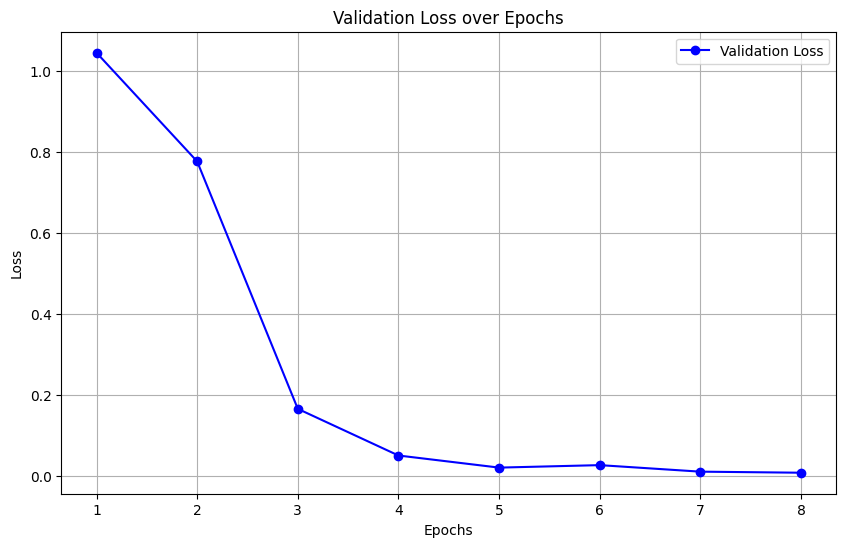

In [ ]:
import matplotlib.pyplot as plt

# Plot validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



<br>

#### **Etape 5 : Evaluation du modèle sur les données de Test, données extérieures à l'apprentissage**

<br>

In [ ]:

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0088, Test Accuracy: 99.76%


<br>
#### **Etape 6 : à vous de jouer !**
<br>
<br>
Ce que vous avez fait ici est du transfer learning. Reprenez l'apprentissage en défreezant tout d'abord les couches fully connected, puis les couches convolutives, pour voir l'effet de finetuné le modèle de fondation.
<br>
<br>
Pouvez-vous déceler dans les nouvelles valeurs de loss train/valid une différence avec le transfer learning?


